In [48]:
import os
from glob import glob
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from matplotlib.patches import Patch, Rectangle
plt.rc('text', usetex=True)


import matplotlib

import geopandas as gpd

import pandas as pd

import scalebar

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage import exposure

from shapely import geometry

import json

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling, array_bounds

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns

%matplotlib inline

# Map of Colorado ASO Performance

In [2]:
root = '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip'
# root = "/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172635_0f2d_3B_AnalyticMS_SR_clip"

In [3]:
os.listdir(root)

['20180524_172637_0f2d_3B_Visual.tif',
 '32776e534dede28c6635a4f4a15f723a',
 'data-mask.geojson',
 'data-mask.geojson_clipped.geojson',
 'mask',
 'preds',
 'tile_no.txt',
 'veg']

In [4]:
imagepath = root.split("/")[-1].split(":")[-1]
print(imagepath)

20180524_172637_0f2d_3B_AnalyticMS_SR_clip


In [5]:
mask_ds = rio.open(glob(os.path.join(root, "mask/*merged*.tif"))[0])
mask_data = mask_ds.read(1, masked=True)
nozero_mask = np.ma.masked_array(mask_data, mask_data == 0)

In [6]:
extent = [mask_ds.bounds[0], mask_ds.bounds[2], mask_ds.bounds[1], mask_ds.bounds[3]]
extent

[-107.127685546875, -106.995849609375, 39.01918781175702, 39.087436032158834]

In [8]:
nir_image = rio.open(glob(os.path.join(root, "*clip_visual_edit.tif"))[0])


IndexError: list index out of range

In [9]:
data_region = gpd.read_file(os.path.join(root, "data-mask.geojson"))

In [10]:
def plot_mask(mask, extent, ax, cmap, alpha=1):
    
    im = ax.imshow(mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap, alpha=alpha)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False

    
def plot_diff(mask, pred, extent, ax, alpha=1):
    diff = mask - pred
    im = ax.imshow(diff, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=-1, vmax=1, cmap='RdBu', alpha=alpha)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    return(im)


In [11]:
nodata_diff = geometry.Polygon.from_bounds(*mask_ds.bounds).difference(data_region.geometry.iloc[0])

In [12]:
extent

[-107.127685546875, -106.995849609375, 39.01918781175702, 39.087436032158834]

In [13]:
nir_image = rio.open(glob(os.path.join(root, "*clip.tif"))[0])

nir_reproject = None
ndsi_reproject = None
with nir_image as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds)

    
    green = src.read(2, masked=True) 
    NIR = src.read(4, masked=True) 
    ndsi = (green - NIR) / (green + NIR)
    
    ndsi_reproject = np.zeros((height, width), dtype=float)

    reproject(
        source=ndsi / 10000,
        src_nodata=src.nodata, 
        dst_nodata=src.nodata,
        destination=ndsi_reproject,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs="EPSG:4326",
        resampling=Resampling.nearest)

    nir_reproject = np.zeros((height, width), dtype=float)
    reproject(
        source=src.read(4) / 10000,
        src_nodata=src.nodata, 
        dst_nodata=src.nodata,
        destination=nir_reproject,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs="EPSG:4326",
        resampling=Resampling.nearest)
    
    nir_reproject = np.ma.masked_array(nir_reproject, nir_reproject == src.nodata)
    bounds = array_bounds(height, width, transform)
    image_reproject_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]


IndexError: list index out of range

In [14]:
pred_ds = rio.open(glob(os.path.join(root, "preds/*merged*.tif"))[0])
pred_data = pred_ds.read(1, masked=True)
nozero_pred = np.ma.masked_array(pred_data, pred_data == 0)

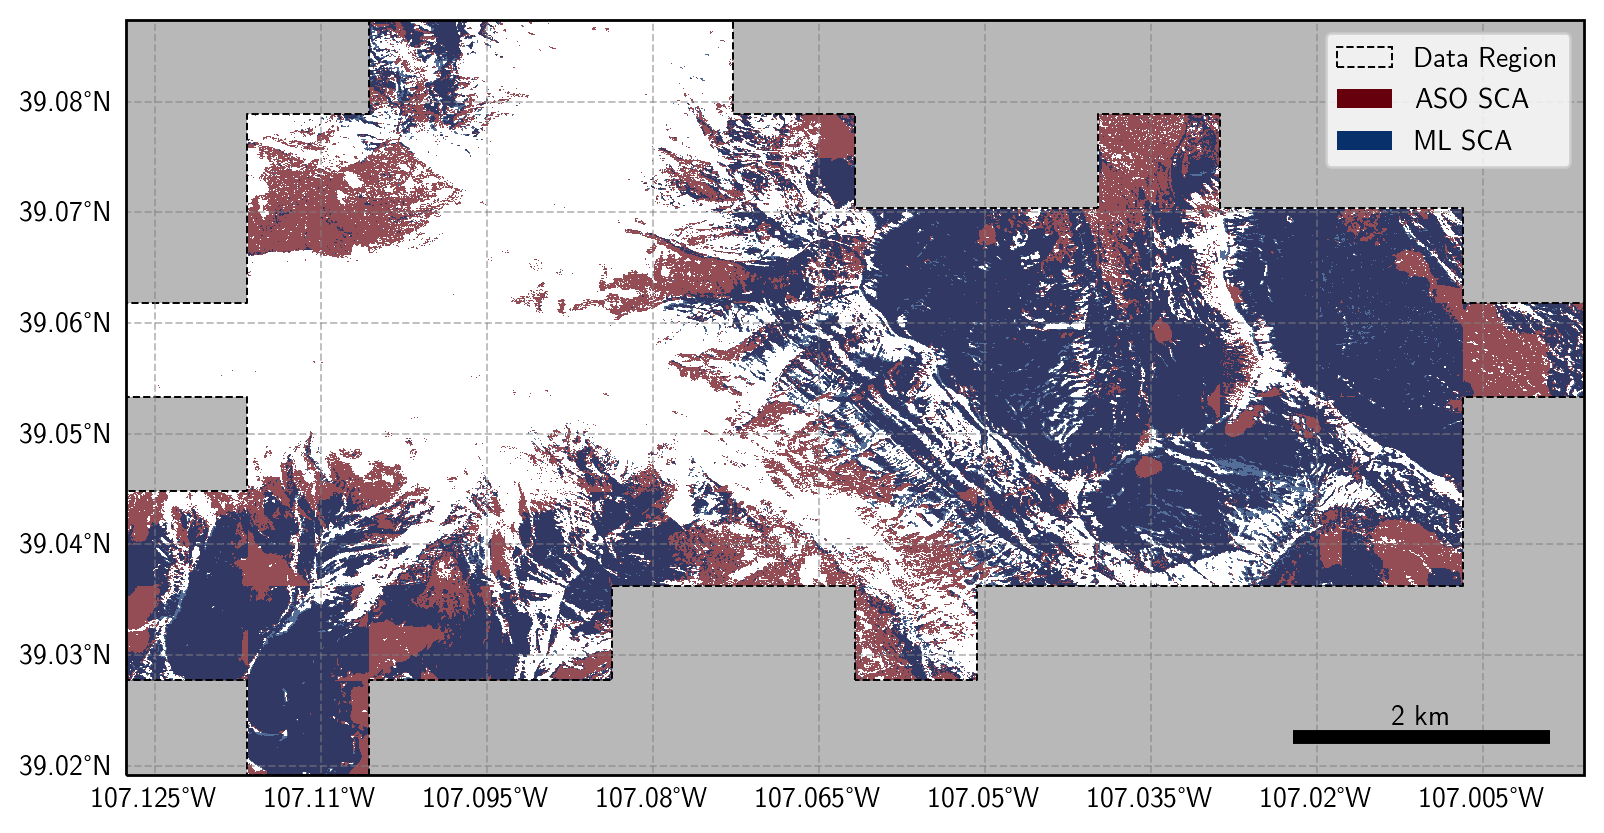

In [15]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


# plot_mask(nozero_mask, extent, ax, cmap=cmap, alpha=0.9)

im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


ax.legend(handles=legendParts)

# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.savefig("test_image.png")

## Plot with additional barplots

In [16]:
os.path.dirname(root)

'/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO'

In [17]:
# from `model-comparison.ipynb`
metrics = pd.read_csv(os.path.join(os.path.dirname(root), "comparator-metrics.csv"))
metrics

Unnamed: 0  index             SCA  \
0             0      0      CubeSat ML   
1             1      1      CubeSat ML   
2             2      2      CubeSat ML   
3             3      3      CubeSat ML   
4             4      4      CubeSat ML   
..          ...    ...             ...   
175         175      7  Landsat 8 fSCA   
176         176      8  Landsat 8 fSCA   
177         177      9  Landsat 8 fSCA   
178         178     10  Landsat 8 fSCA   
179         179     11  Landsat 8 fSCA   

                                       image_id   variable     value  
0    20180524_172142_103d_3B_AnalyticMS_SR_clip  Precision  0.958382  
1    20180524_172143_103d_3B_AnalyticMS_SR_clip  Precision  0.833033  
2    20180524_172144_103d_3B_AnalyticMS_SR_clip  Precision  0.792962  
3    20180524_172145_103d_3B_AnalyticMS_SR_clip  Precision  0.856812  
4    20180524_172326_0f51_3B_AnalyticMS_SR_clip  Precision  0.738694  
..                                          ...        ...       ...  
175  20180524_172330_0f51_3B_AnalyticMS_SR_clip      Kappa  0.561309  
176  20180524_172331_0f51_3B_AnalyticMS_SR_clip      Kappa  0.395526  
177  20180524_172634_0f2d_3B_AnalyticMS_SR_clip      Kappa  0.452726  
178  20180524_172635_0f2d_3B_AnalyticMS_SR_clip      Kappa  0.723014  
179  20180524_172637_0f2d_3B_AnalyticMS_SR_clip      Kappa  0.716405  

[180 rows x 6 columns]

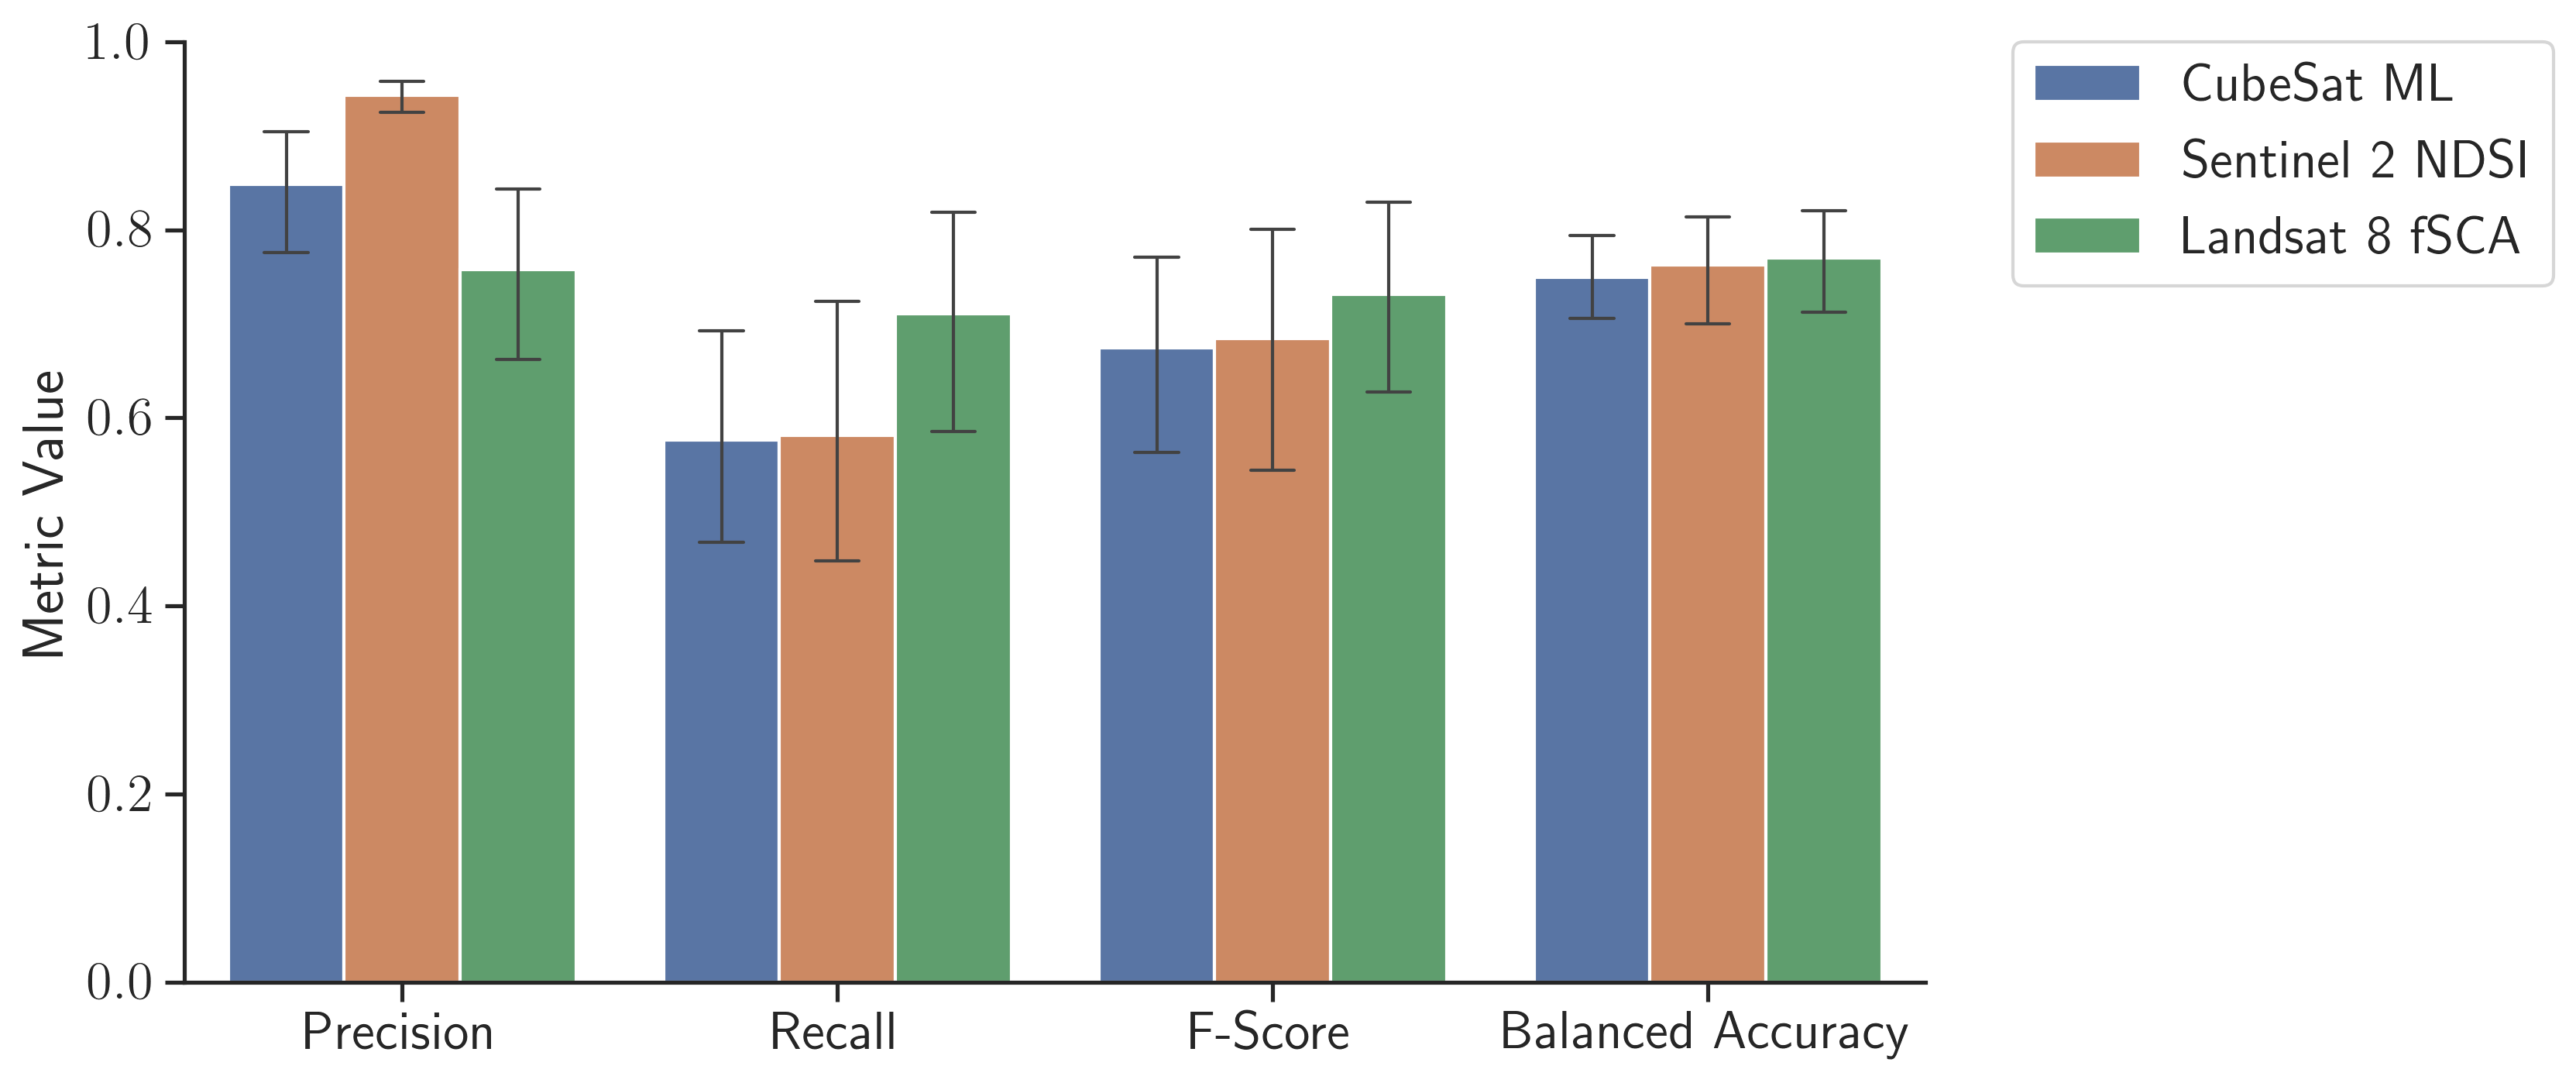

In [18]:

sns.set(style='ticks', font_scale=1.5)

fig, ax = plt.subplots(figsize=(11.5,5), dpi=300)
bp = sns.barplot(x='variable', hue='SCA', y = 'value',
                 data=metrics, ax= ax, 
                 order=['Precision', "Recall", "F-Score", "Balanced Accuracy"],
                 capsize=0.1, errwidth=1)
plt.ylim([0, 1])
plt.xlabel("")
plt.ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.savefig("performance.png", dpi=300, bbox_inches='tight')


# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

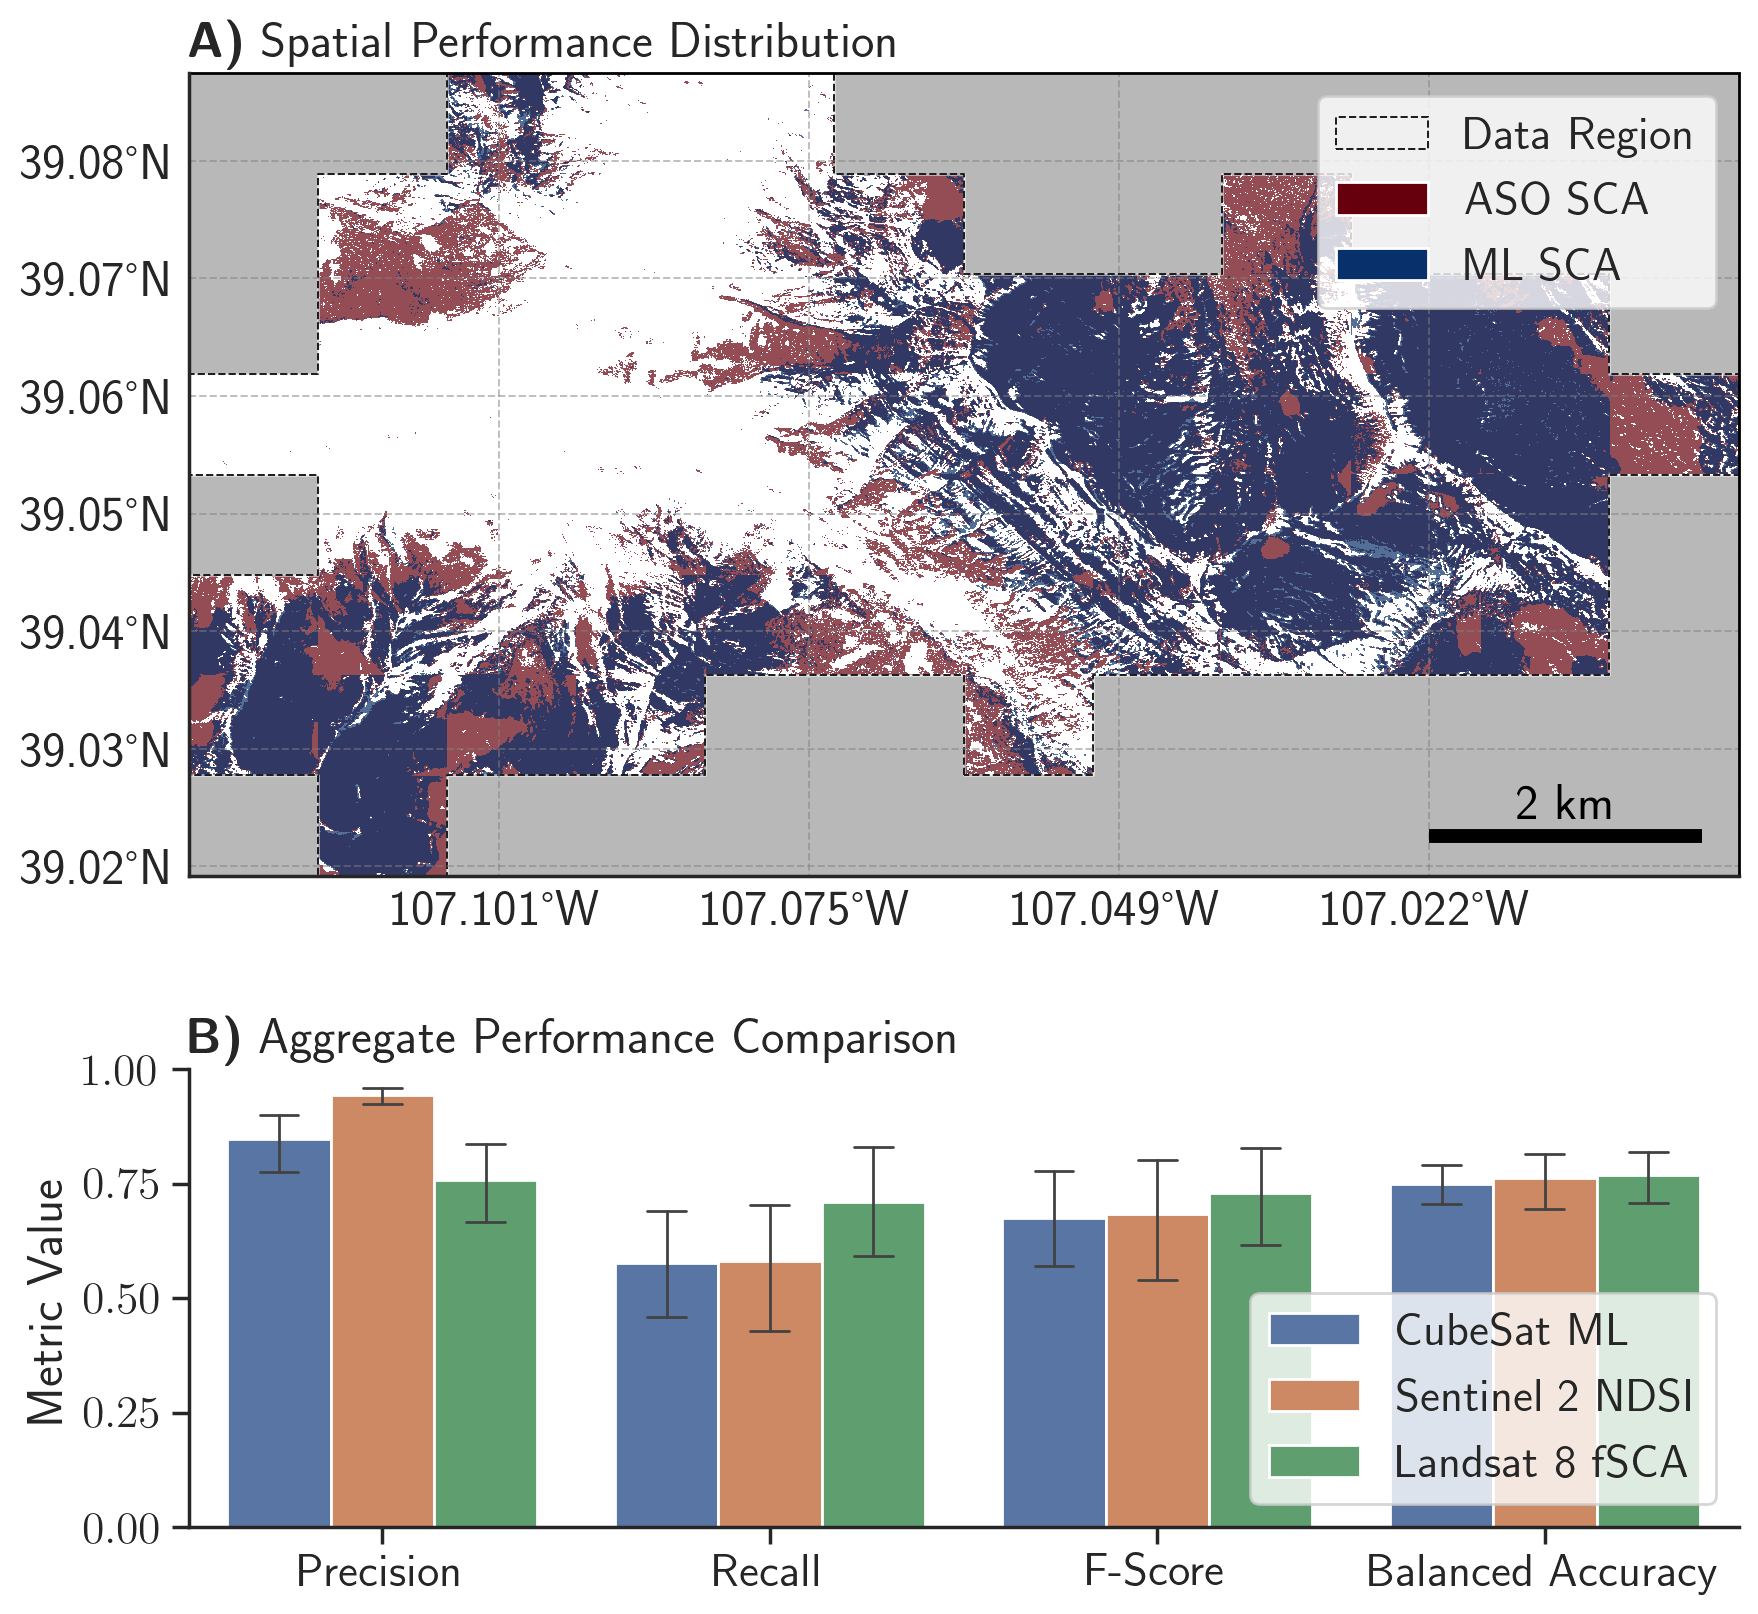

In [19]:
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(10,10), dpi=200)
grid = fig.add_gridspec(2, 1, height_ratios=[4,2])

ax = fig.add_subplot(grid[0], projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)


gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

ax.legend(handles=legendParts)
ax.set_title(r"\textbf{A)}" + " Spatial Performance Distribution", loc='left')



scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())

ax_bars = fig.add_subplot(grid[1])


sns.set(style='ticks', font_scale=1.5)

bp = sns.barplot(x='variable', hue='SCA', y = 'value',
                 data=metrics, ax= ax_bars, 
                 order=['Precision', "Recall", "F-Score", "Balanced Accuracy"],
                 capsize=0.1, errwidth=1)
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("")
ax_bars.set_ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax_bars.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# ax_bars.tight_layout()
ax_bars.set_title(r"\textbf{B)}" + " Aggregate Performance Comparison", loc='left')

ax_bars.legend(loc='lower right')

# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

plt.savefig(f"{imagepath}_combo_image.png", dpi=300, bbox_inches='tight', transparent=True)

## Add Visual Asset, since we have it

In [20]:
visual = glob(os.path.join(root, "*Visual.tif"))
if len(visual) > 0:
    visual = visual[0]

In [21]:



visual_reproject = None
with rio.open(visual) as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds)
    
    visual_reproject = np.zeros((src.count, height, width), dtype=float)


    for band in range(1, src.count + 1):
        reproject(
            source=src.read(band),
            src_nodata=src.nodata, 
            dst_nodata=src.nodata,
            destination=visual_reproject[band - 1, :, :],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs="EPSG:4326",
            resampling=Resampling.nearest)

    visual_reproject = np.ma.masked_array(visual_reproject, visual_reproject == src.nodata).astype('int')
    bounds = array_bounds(height, width, transform)
    visual_reproject_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]


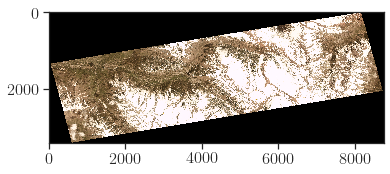

In [22]:
plt.imshow(np.stack([
    visual_reproject[0], 
    visual_reproject[1],
    visual_reproject[2]
], axis=-1))

In [23]:
visual_reproject.astype(int)

masked_array(
  data=[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],
  mask=[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False

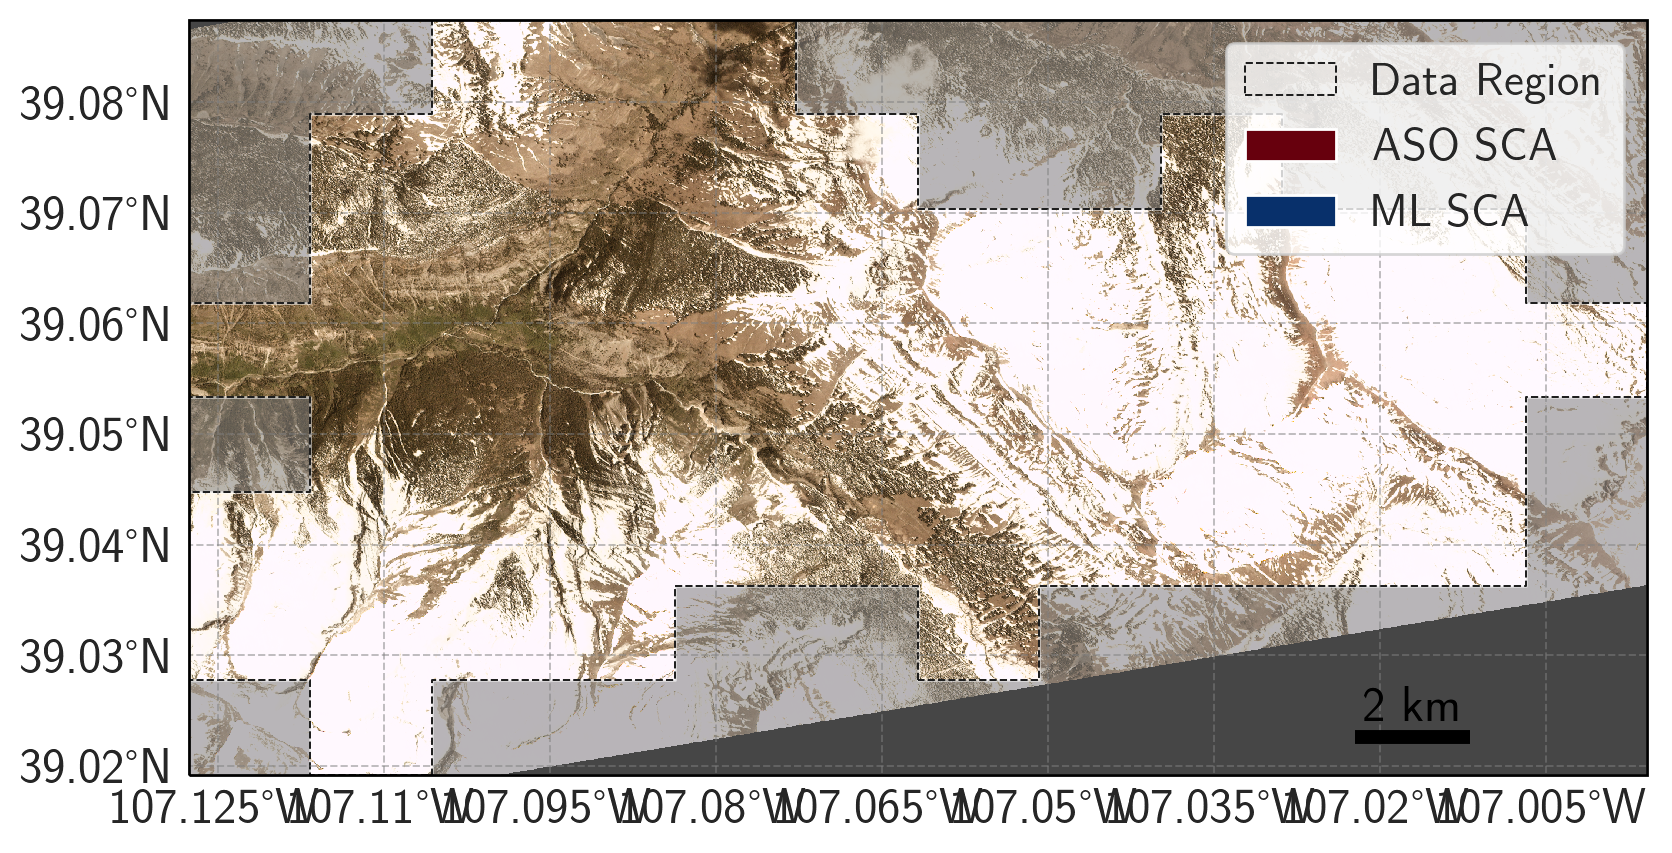

In [24]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


# plot_mask(nozero_mask, extent, ax, cmap=cmap, alpha=0.9)

ax.imshow(np.stack([
    visual_reproject[0], 
    visual_reproject[1],
    visual_reproject[2]
], axis=-1), extent=visual_reproject_extent, transform=ccrs.PlateCarree(), origin='upper')
# im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
# im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


ax.legend(handles=legendParts)

# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.savefig("test_image.png")

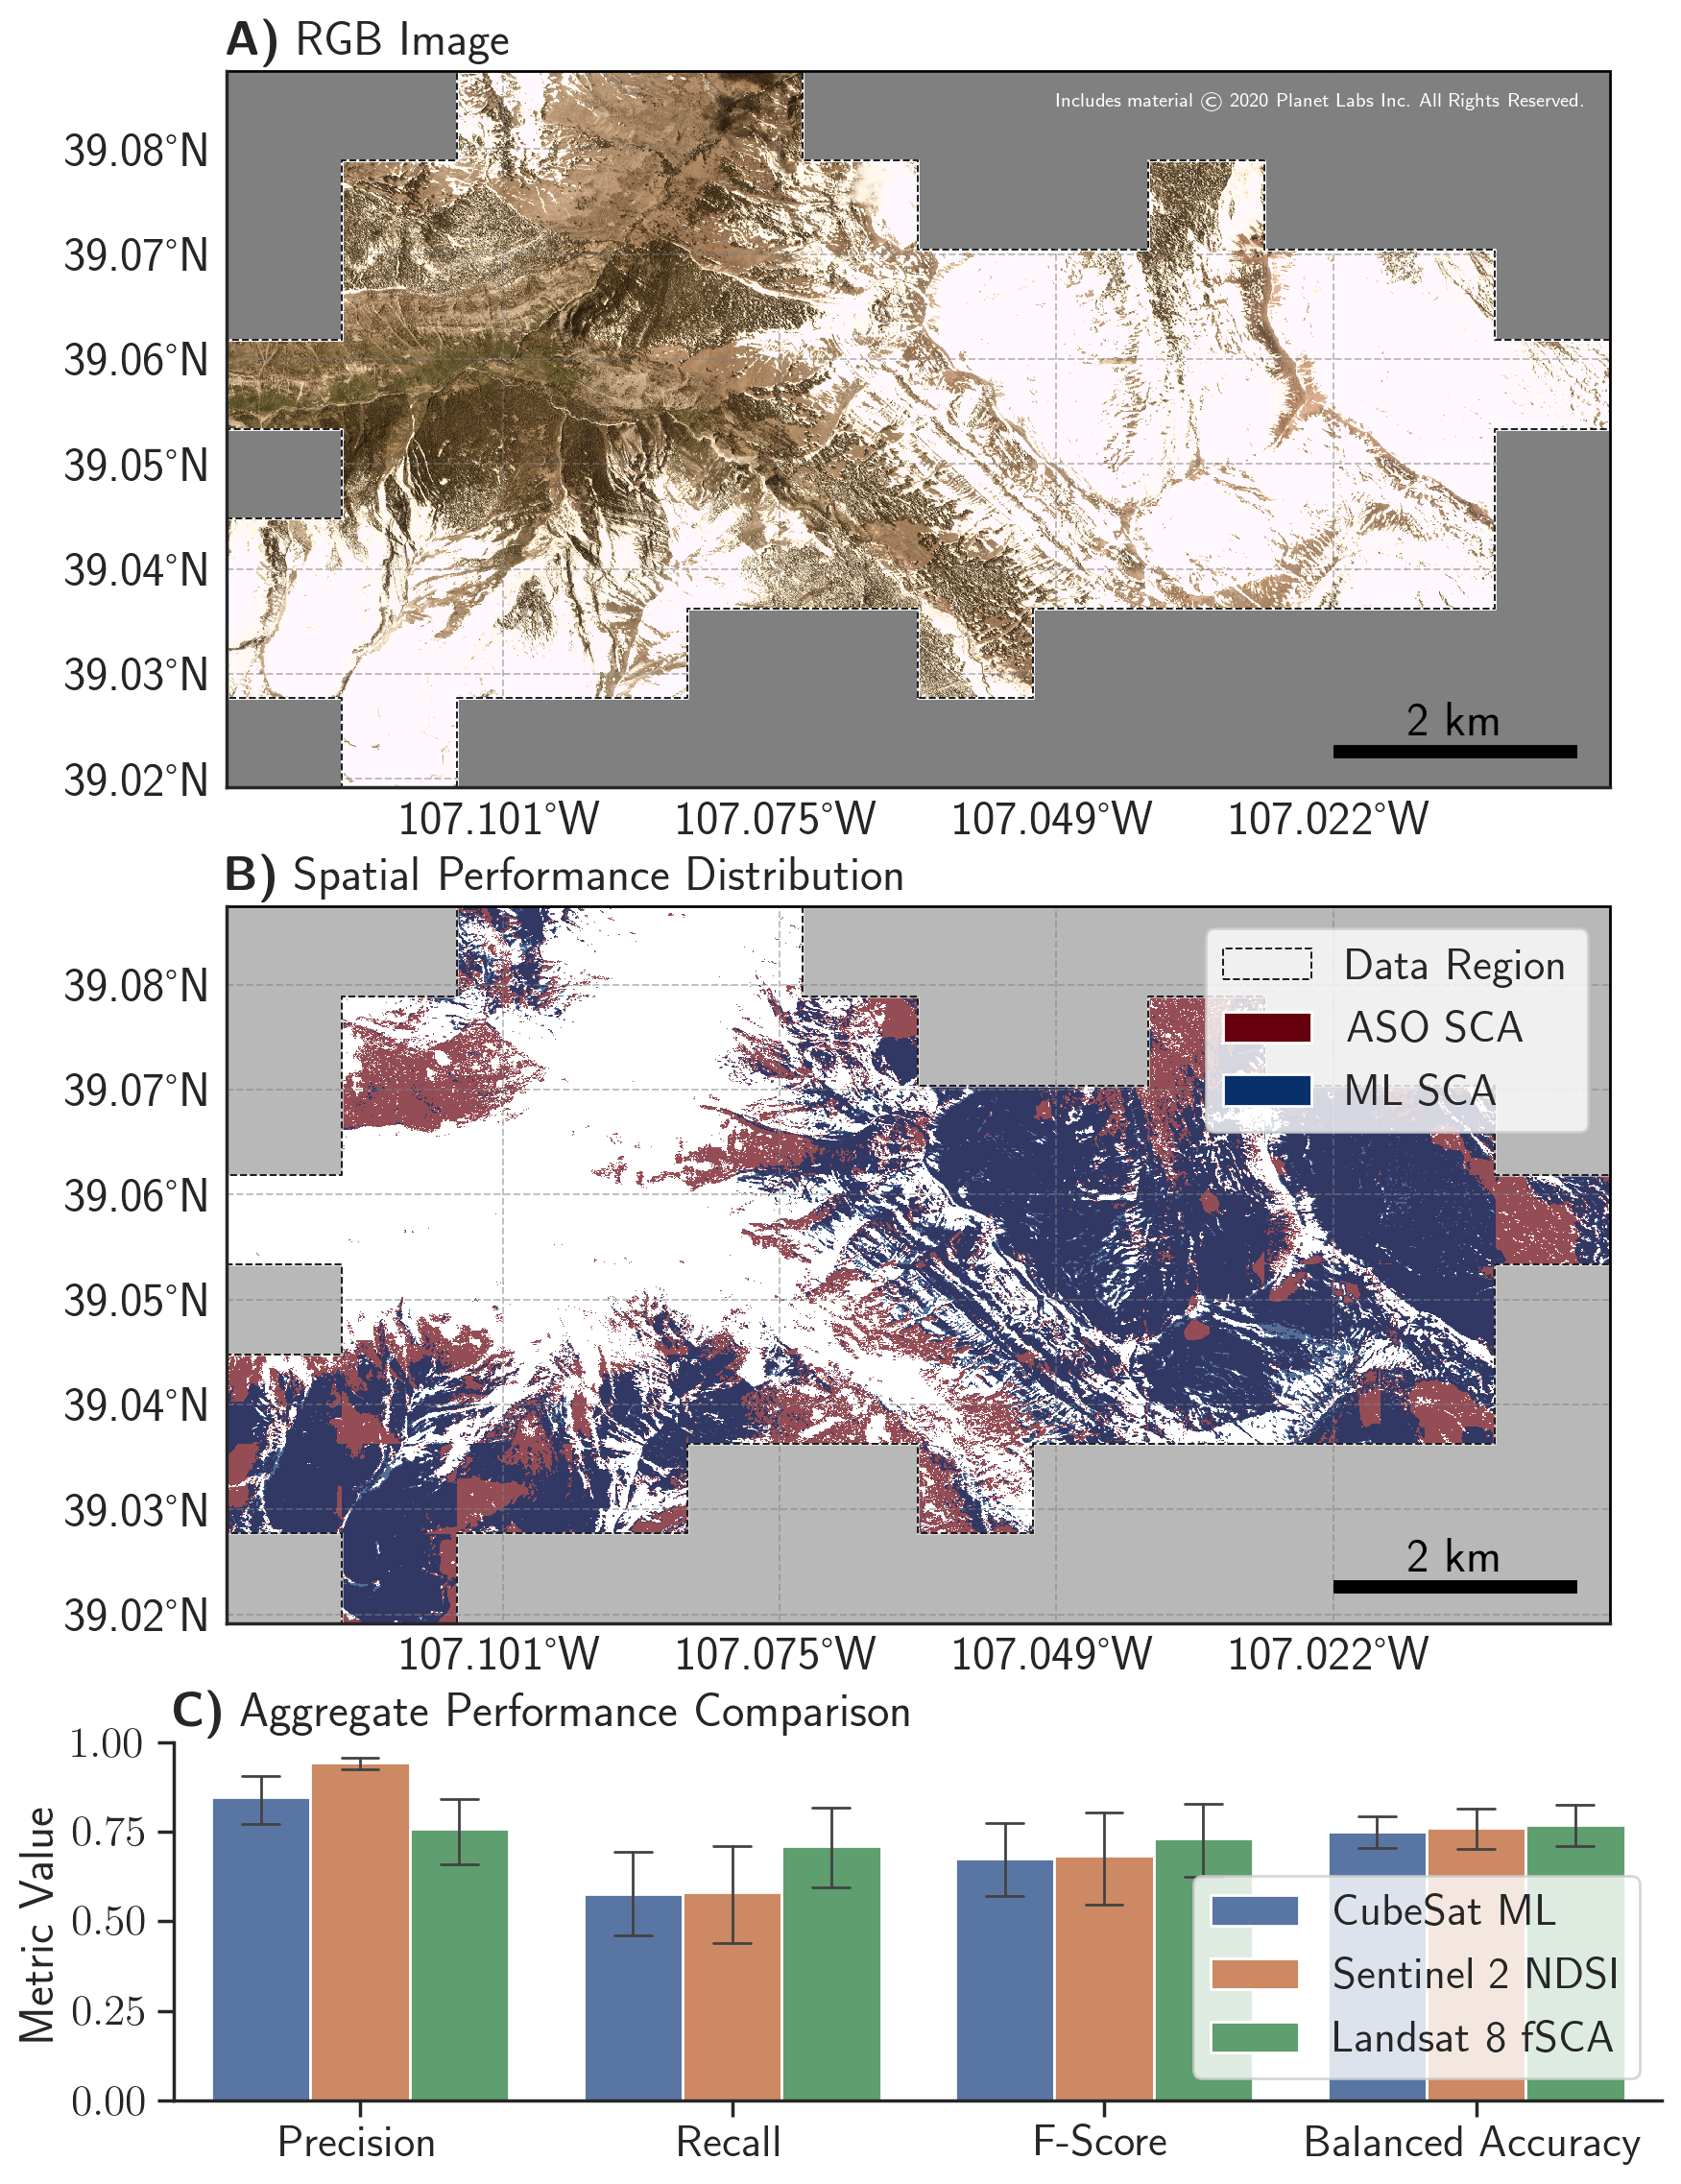

In [25]:
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(10,14), dpi=200)
grid = fig.add_gridspec(3, 1, height_ratios=[4, 4, 2])


ax = fig.add_subplot(grid[0], projection=ccrs.PlateCarree())
ax.imshow(np.stack([
    visual_reproject[0], 
    visual_reproject[1],
    visual_reproject[2]
], axis=-1), extent=visual_reproject_extent, transform=ccrs.PlateCarree(), origin='upper')
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=1)
ax.text(0.6, 0.95, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title(r"\textbf{A)}" + " RGB Image", loc='left')
scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})



ax = fig.add_subplot(grid[1], projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)


gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

ax.legend(handles=legendParts)
ax.set_title(r"\textbf{B)}" + " Spatial Performance Distribution", loc='left')



scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())

ax_bars = fig.add_subplot(grid[2])


sns.set(style='ticks', font_scale=1.5)

bp = sns.barplot(x='variable', hue='SCA', y = 'value',
                 data=metrics, ax= ax_bars, 
                 order=['Precision', "Recall", "F-Score", "Balanced Accuracy"],
                 capsize=0.1, errwidth=1)
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("")
ax_bars.set_ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax_bars.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# ax_bars.tight_layout()
ax_bars.set_title(r"\textbf{C)}" + " Aggregate Performance Comparison", loc='left')

ax_bars.legend(loc='lower right')

# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

plt.savefig(f"{imagepath}_combo_image.png", dpi=300, bbox_inches='tight', transparent=False)

## Vegetation Performance

In [40]:
these_metrics = metrics[
    (metrics.SCA == 'CubeSat ML') & \
    (metrics.image_id == imagepath)].drop(['Unnamed: 0', 'index', 'image_id', 'SCA'], axis=1).assign(type = 'All Pixels')

In [42]:
veg_metrics = pd.concat([pd.read_csv(os.path.join(root, "veg/veg_metrics.csv")).drop(['comparator'], axis=1), these_metrics])

veg_metrics

/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


type     value           variable
0      No Vegetation  0.924332          Precision
1    Vegetation Only  0.888728          Precision
2      No Vegetation  0.838694             Recall
3    Vegetation Only  0.454737             Recall
4      No Vegetation  0.879433            F-Score
5    Vegetation Only  0.601635            F-Score
6      No Vegetation  0.848016  Balanced Accuracy
7    Vegetation Only  0.706727  Balanced Accuracy
11        All Pixels  0.912100          Precision
47        All Pixels  0.677635             Recall
83        All Pixels  0.777577            F-Score
119       All Pixels  0.800977  Balanced Accuracy
155       All Pixels  0.589904              Kappa

In [45]:
veg_metrics = veg_metrics[veg_metrics.variable != 'Kappa']

In [50]:
colors = [
    cm.Greens(0.8), # veg,
    sns.xkcd_rgb['brownish'],
    sns.xkcd_rgb['blue']
    #     'grey'#     cm.Greens(0.3), # veg,

]
cmap = sns.color_palette(colors)

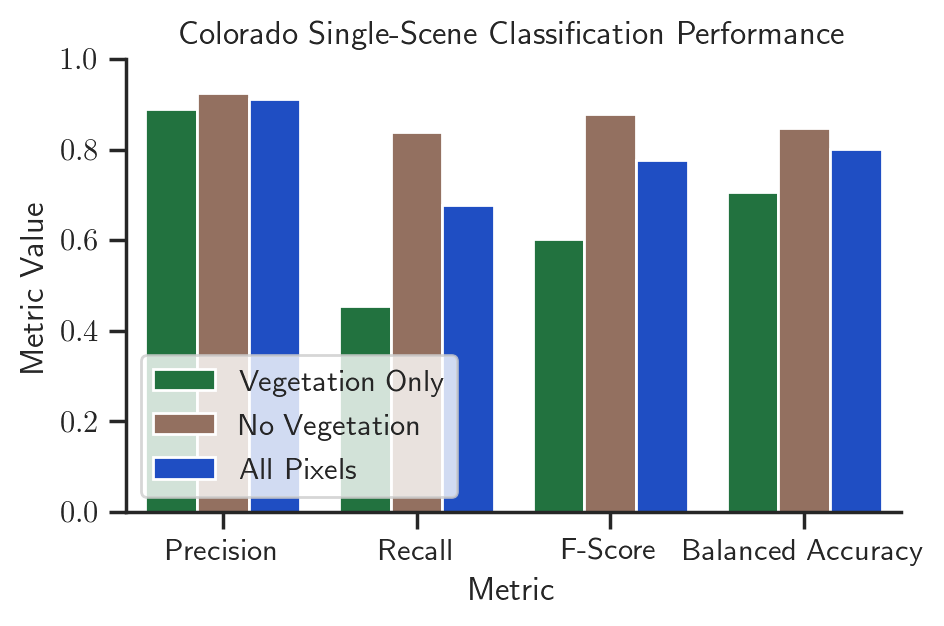

In [51]:
sns.set(style='ticks')
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(5,3), dpi=200)
sns.barplot(x='variable', y='value', hue='type', data=veg_metrics, hue_order=['Vegetation Only', "No Vegetation", 'All Pixels'], palette=cmap, dodge=True)
plt.legend(loc='lower left')
plt.ylim([0, 1])
plt.xlabel("Metric")
plt.ylabel("Metric Value")
plt.title("Colorado Single-Scene Classification Performance")
sns.despine()

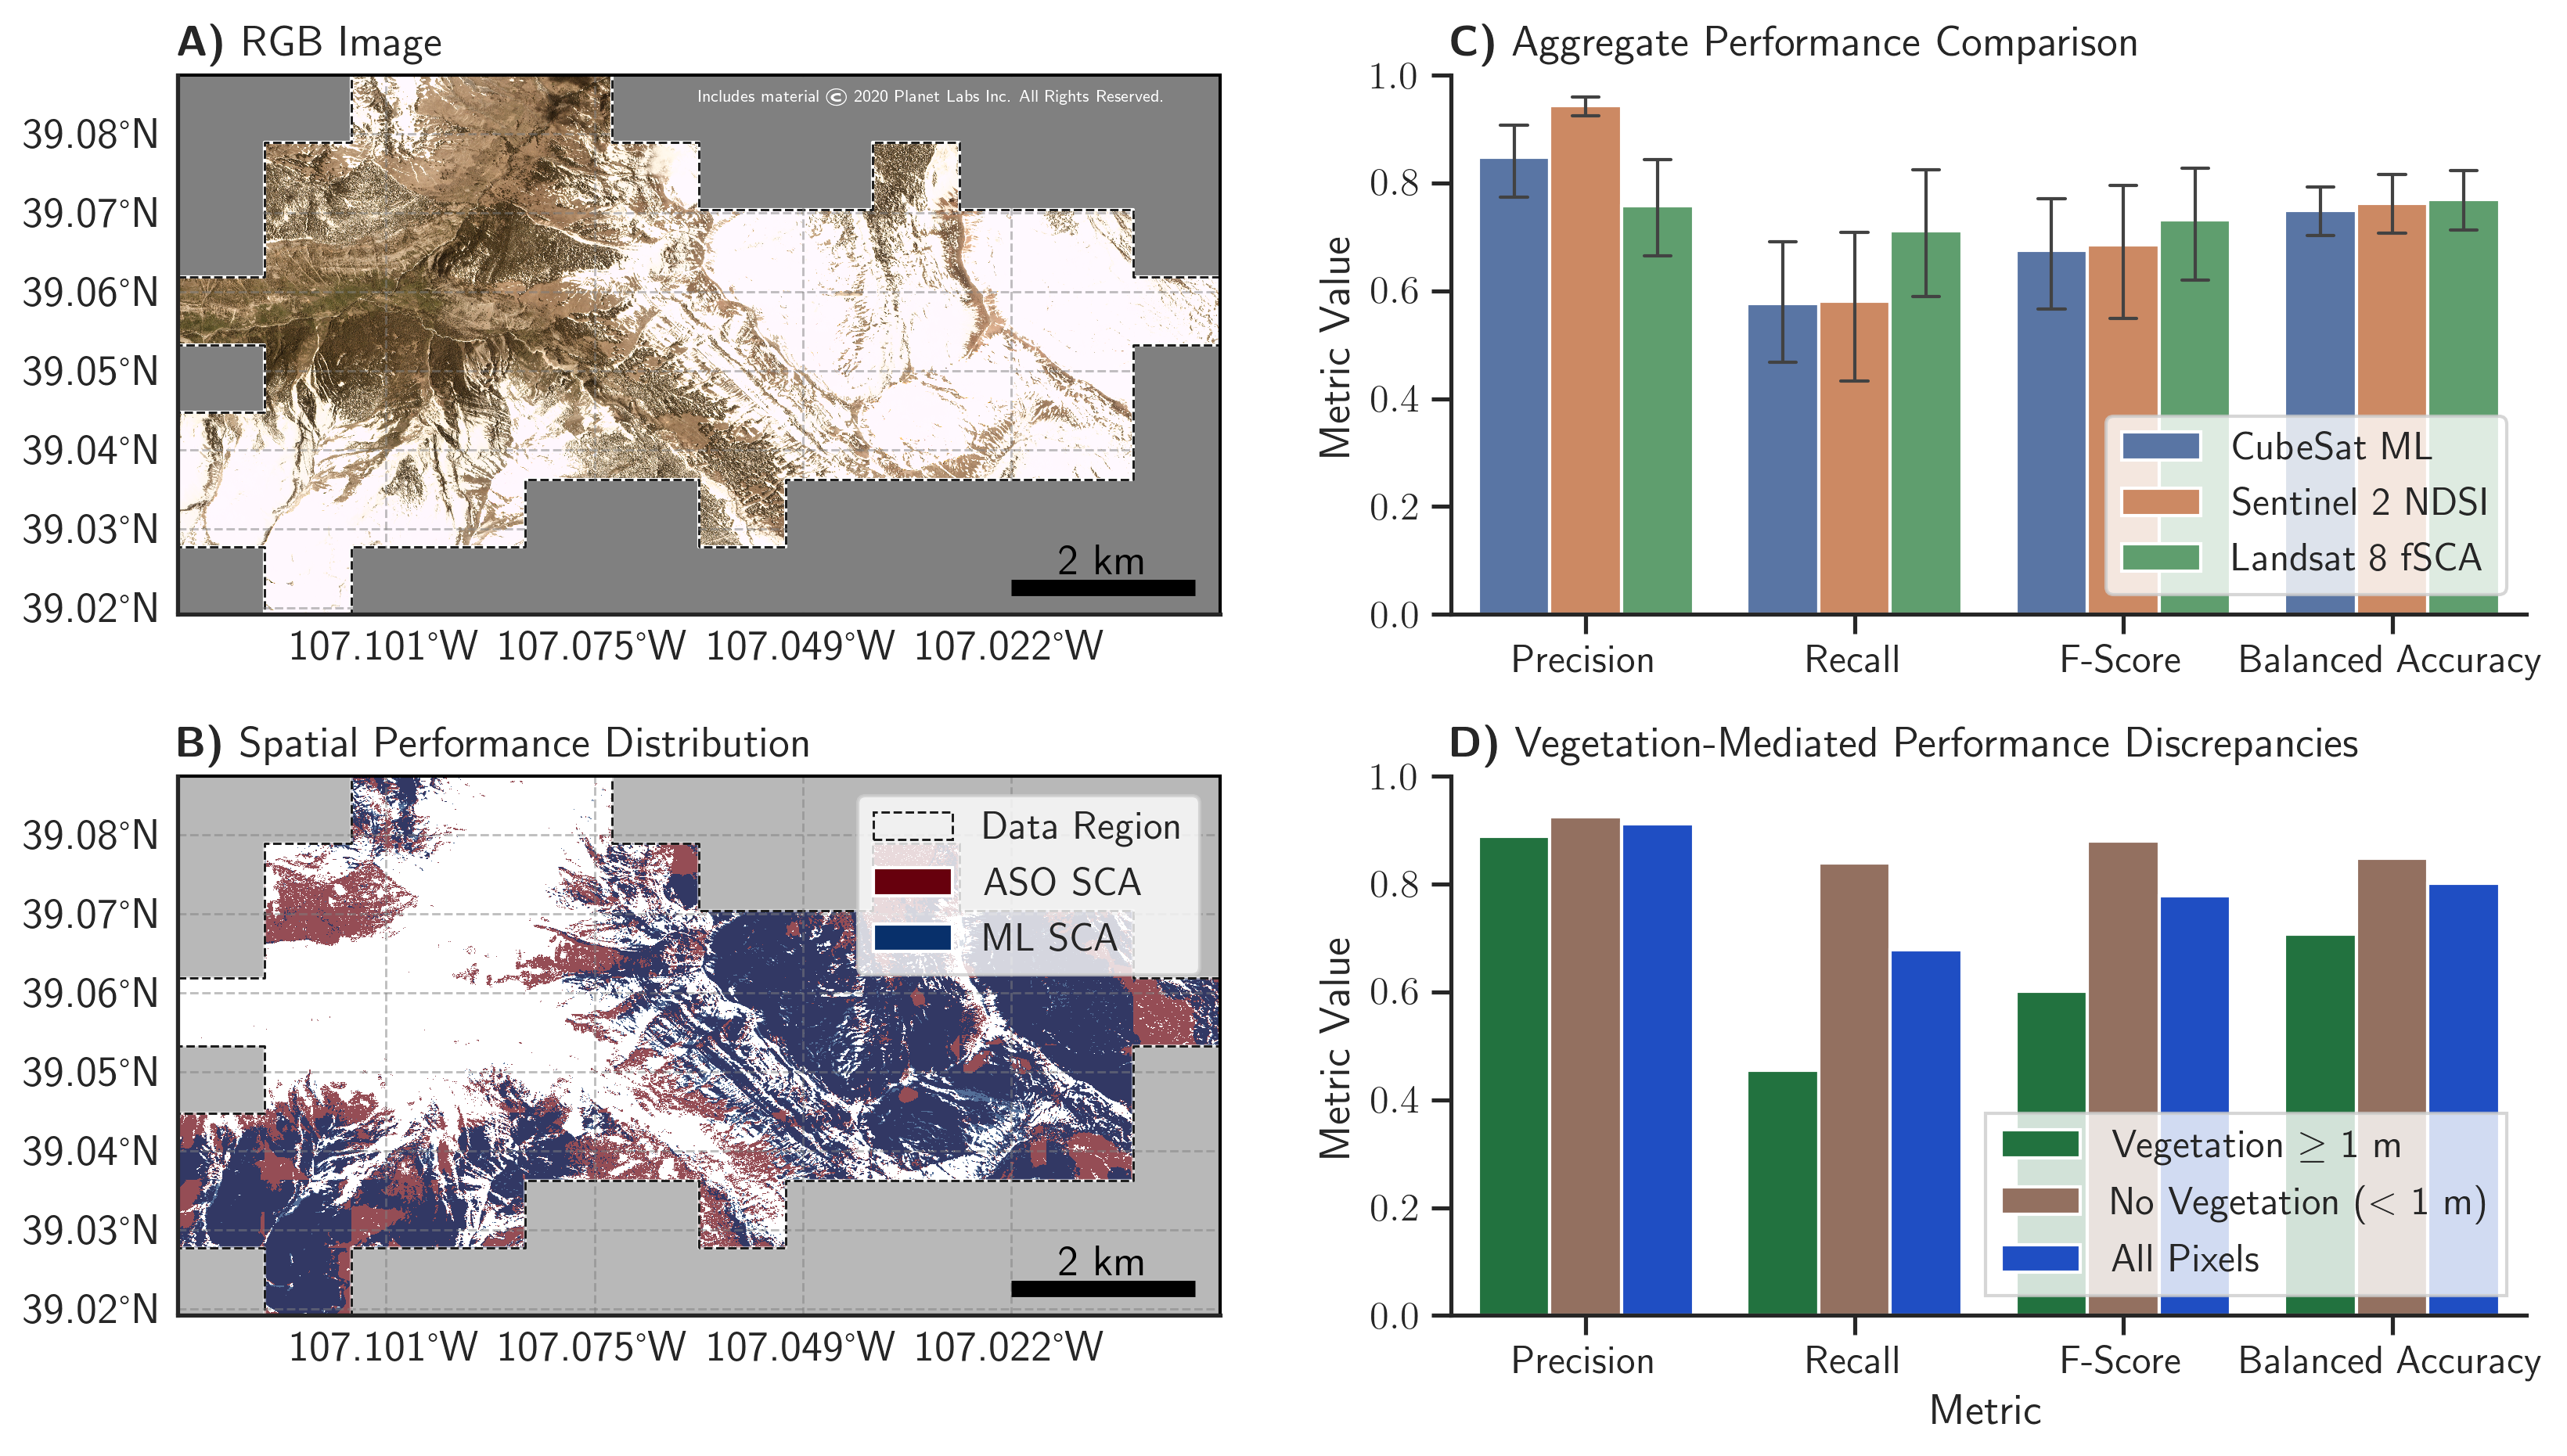

In [63]:
plt.rc('text', usetex=True)
sns.set(style='ticks', font_scale=1.1)

fig = plt.figure(figsize=(13,7), dpi=300)
grid = fig.add_gridspec(2, 2, width_ratios=[1,1], hspace=0.3)


ax = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree())
ax.imshow(np.stack([
    visual_reproject[0], 
    visual_reproject[1],
    visual_reproject[2]
], axis=-1), extent=visual_reproject_extent, transform=ccrs.PlateCarree(), origin='upper')
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=1)
ax.text(0.5, 0.95, r"Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 5})


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title(r"\textbf{A)}" + " RGB Image", loc='left')
scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})



ax = fig.add_subplot(grid[1, 0], projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)


gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

ax.legend(handles=legendParts)
ax.set_title(r"\textbf{B)}" + " Spatial Performance Distribution", loc='left')



scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})
ax.set_extent(extent, crs=ccrs.PlateCarree())


ax_bars = fig.add_subplot(grid[0, 1])


# sns.set(style='ticks', font_scale=1.5)

bp = sns.barplot(x='variable', hue='SCA', y = 'value',
                 data=metrics, ax= ax_bars, 
                 order=['Precision', "Recall", "F-Score", "Balanced Accuracy"],
                 capsize=0.1, errwidth=1)
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("")
ax_bars.set_ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax_bars.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# ax_bars.tight_layout()
ax_bars.set_title(r"\textbf{C)}" + " Aggregate Performance Comparison", loc='left')

ax_bars.legend(loc='lower right')


ax_bars = fig.add_subplot(grid[1, 1])


bars = sns.barplot(x='variable', y='value', hue='type', data=veg_metrics, hue_order=['Vegetation Only', "No Vegetation", 'All Pixels'], palette=cmap, dodge=True)
ax_bars.legend(loc='lower right')
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("Metric")
ax_bars.set_ylabel("Metric Value")
ax_bars.set_title(r"\textbf{D)}" + " Vegetation-Mediated Performance Discrepancies", loc='left')
h, l = bars.get_legend_handles_labels()
l = [
    r"Vegetation $\ge$ 1 m",
    r"No Vegetation ($<$ 1 m)",
    r"All Pixels"
]
bars.legend(h,l,loc='lower right', frameon=True, fancybox=False)
sns.despine()

# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

plt.savefig(f"{imagepath}_combo_image.png", dpi=300, bbox_inches='tight', transparent=False)